## 3. Purely Louvain Algorithm Implementation

In [9]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import time
import community as community_louvain
import tracemalloc
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [10]:
emb_norm = np.load("../data/embeddings_FINAL.npy") 
df = pd.read_pickle("../data/games_df_FINAL.pkl")

# print(emb_norm.shape)
# print(df.shape)

### 3.1 Construct Louvain's Starting Graph with weighted edges based in cosine similarity

In [11]:
# build a graph for a given threshold
def build_graph_from_sim(sim_matrix, threshold: float) -> nx.Graph:
    """
    Build an undirected graph where nodes are indices in sim_matrix
    and edges are added for similarities > threshold.
    """
    t0 = time.time()
    n = sim_matrix.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Vectorized: find all (i, j) with sim > threshold and i<j
    rows, cols = np.where(sim_matrix > threshold)
    mask = rows < cols
    rows, cols = rows[mask], cols[mask]

    for i, j in zip(rows, cols):
        G.add_edge(int(i), int(j), weight=float(sim_matrix[i, j]))
        
    print(
        f"Graph built: nodes={G.number_of_nodes()}, "
        f"edges={G.number_of_edges()}, "
        f"time={time.time() - t0:.2f}s"
    )

    return G

In [12]:
# Cosine similarity
t0 = time.time()
sim_matrix = cosine_similarity(emb_norm)
print("Cosine similarity done in:", time.time() - t0, "sec")

Cosine similarity done in: 1.1278071403503418 sec


In [13]:
# === Example with threshold 0.8 ===

threshold = 0.8  # Do not add all edges

G = build_graph_from_sim(sim_matrix, threshold)

print("Vertices:", G.number_of_nodes())
print("Edges:", G.number_of_edges()) 

Graph built: nodes=10476, edges=2390, time=0.46s
Vertices: 10476
Edges: 2390


### 3.2 Execute Louvain, Save & Analysis

In [14]:
def evaluate_louvain(
    G: nx.Graph,
    embeddings: np.ndarray,
    resolution: float = 1.0,
    seed: int = 0,
) -> dict:
    """
    Run Louvain on graph G, compute:
    - modularity
    - #clusters, cluster sizes
    - silhouette, Davies–Bouldin on embeddings
    - runtime, peak memory
    Returns a dict of metrics.
    """
    # Measure memory + time
    tracemalloc.start()
    t0 = time.time()

    partition = community_louvain.best_partition(
        G,
        weight="weight",
        resolution=resolution,
        random_state=seed,
    )

    runtime = time.time() - t0
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_mb = peak / (1024 ** 2)

    # Partition -> labels array aligned with node indices
    # nodes are 0..N-1, same as rows in embeddings
    labels = np.array([partition[i] for i in range(len(partition))])
    n_clusters = len(np.unique(labels))

    # Cluster size stats
    cluster_sizes = pd.Series(labels).value_counts()
    largest_cluster = int(cluster_sizes.max())
    smallest_cluster = int(cluster_sizes.min())

    # Modularity
    modularity = community_louvain.modularity(partition, G, weight="weight")

    # Silhouette / DB on embeddings (only if >1 cluster and not all singletons)
    try:
        if n_clusters > 1 and largest_cluster > 1:
            sil = silhouette_score(embeddings, labels)
            db = davies_bouldin_score(embeddings, labels)
        else:
            sil = np.nan
            db = np.nan
    except Exception as e:
        print("Metric error:", e)
        sil = np.nan
        db = np.nan

    return {
        "resolution": resolution,
        "seed": seed,
        "n_clusters": n_clusters,
        "largest_cluster": largest_cluster,
        "smallest_cluster": smallest_cluster,
        "modularity": modularity,
        "silhouette": sil,
        "davies_bouldin": db,
        "runtime_sec": runtime,
        "peak_mem_mb": peak_mb,
    }, partition


In [15]:
# Run evaluation for the example from before
metrics, partition = evaluate_louvain(G, emb_norm, resolution=1.0, seed=42)

In [16]:
# Save outputs of the example
with open("partition_louvain_puro.pkl", "wb") as f:
    pickle.dump(partition, f)

with open("graph_louvain_puro.pkl", "wb") as f:
    pickle.dump(G, f)

print("Saved Louvain outputs.")

Saved Louvain outputs.


#### 3.2.1 Louvain's Evaluation

In [17]:
# Evaluation of the example

cluster_sizes = Counter(partition.values())
print("Cluster size distribution:")
for cid, size in cluster_sizes.most_common():
    print(f"Cluster {cid}: {size} games")

Cluster size distribution:
Cluster 167: 65 games
Cluster 190: 55 games
Cluster 69: 46 games
Cluster 592: 30 games
Cluster 786: 28 games
Cluster 413: 22 games
Cluster 2029: 22 games
Cluster 3312: 22 games
Cluster 263: 21 games
Cluster 354: 21 games
Cluster 1658: 19 games
Cluster 185: 17 games
Cluster 196: 17 games
Cluster 169: 16 games
Cluster 1607: 16 games
Cluster 2855: 12 games
Cluster 130: 10 games
Cluster 4986: 10 games
Cluster 570: 9 games
Cluster 1411: 9 games
Cluster 685: 8 games
Cluster 2271: 8 games
Cluster 4732: 7 games
Cluster 426: 6 games
Cluster 1490: 6 games
Cluster 119: 5 games
Cluster 176: 5 games
Cluster 258: 5 games
Cluster 265: 5 games
Cluster 959: 5 games
Cluster 1259: 5 games
Cluster 2152: 5 games
Cluster 2325: 5 games
Cluster 2602: 5 games
Cluster 2982: 5 games
Cluster 3578: 5 games
Cluster 70: 4 games
Cluster 208: 4 games
Cluster 328: 4 games
Cluster 433: 4 games
Cluster 765: 4 games
Cluster 1039: 4 games
Cluster 1046: 4 games
Cluster 1121: 4 games
Cluster 1714: 

In [18]:
def average_intra_cluster_similarity(sim_matrix, partition):
    clusters = {}
    for node, cid in partition.items():
        clusters.setdefault(cid, []).append(node)

    intra_sims = {}

    for cid, nodes in clusters.items():
        if len(nodes) < 2:
            intra_sims[cid] = 0
            continue

        sims = []
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                sims.append(sim_matrix[nodes[i], nodes[j]])

        intra_sims[cid] = np.mean(sims)

    return intra_sims

intra = average_intra_cluster_similarity(sim_matrix, partition)

print("\nAverage intra-cluster similarity:")
for cid, sim in sorted(intra.items(), key=lambda x: -x[1])[:10]:
    print(f"Cluster {cid}: {sim:.4f}")


Average intra-cluster similarity:
Cluster 5984: 1.0000
Cluster 4830: 0.9995
Cluster 6742: 0.9930
Cluster 4998: 0.9877
Cluster 5034: 0.9876
Cluster 1490: 0.9840
Cluster 5753: 0.9819
Cluster 4840: 0.9806
Cluster 4407: 0.9774
Cluster 3625: 0.9715


### Visual analysis for Louvains algorithm

In [19]:
def inspect_cluster(cluster_id, df, partition, n=50):
    games = [i for i, c in partition.items() if c == cluster_id]
    return df.iloc[games].head(n)[["game_id", "name", "genres", "summary", ]]

In [20]:
inspect_cluster(69, df, partition)

,game_id,name,genres,summary
69,343605,Hentai Beach,"Indie, Puzzle",Hentai Beach - our warm resort with hot beauties.
229,161575,Hentai Fantasy,"Indie, Strategy",Enjoy the beauty girls picture and relaxing mu...
1251,197305,Naughty Waifu,Indie,Move all parts to form the complete image.
1317,265767,Hentai Vivian,Indie,What could be more beautiful than hentai?
1819,286722,Hentai Karada,"Indie, Strategy",Enjoy the beauty girls picture and relaxing mu...
1887,286726,Hentai Sakyubus,"Indie, Strategy",Enjoy the beauty girls picture and relaxing mu...
2038,286723,Hentai Hentai,"Indie, Strategy",Enjoy the beauty girls picture and relaxing mu...
2638,173853,Neko Hentai Girl,"Adventure, Indie",Only in this game you get AAA-quality nude pic...
3816,156637,Hentai Balloons 2,Indie,Gameplay: Move All Parts to Form the Complete ...
3829,177629,Hentai Clouds,Puzzle,Move the puzzle pieces to complete the drawing.


### Louvains algorithm implementation with different thresholds and evaluation

In [ ]:
thresholds = [0.6, 0.7, 0.8]
resolutions = [0.5, 1.0, 1.5]
seeds = [0]

results = []
partitions_cache = {}  # key: (thr, res, seed) -> partition

for thr in thresholds:
    print(f"\n=== Threshold {thr} ===")
    G_thr = build_graph_from_sim(sim_matrix, thr)
    
    for res in resolutions:
        for seed in seeds:
            print(f"  -> Louvain: res={res}, seed={seed}")
            metrics, partition = evaluate_louvain(
                G_thr,
                emb_norm,
                resolution=res,
                seed=seed,
            )
            metrics_with_thr = {"threshold": thr, **metrics}
            results.append(metrics_with_thr)
            partitions_cache[(thr, res, seed)] = partition

results_df = pd.DataFrame(results)


=== Threshold 0.6 ===
Graph built: nodes=10476, edges=63942, time=0.57s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.7 ===
Graph built: nodes=10476, edges=11714, time=0.40s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.8 ===
Graph built: nodes=10476, edges=2390, time=0.37s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0


In [22]:
results_df

,resolution,seed,n_clusters,largest_cluster,smallest_cluster,modularity,silhouette,davies_bouldin,runtime_sec,peak_mem_mb,threshold
0,0.5,0,4721,1036,1,0.611312,0.006275,1.025748,4.281068,22.954520,0.6
1,1.0,0,4263,1634,1,0.643320,-0.051444,1.001206,9.080266,25.419020,0.6
2,1.5,0,4282,1415,1,0.668266,-0.042392,1.002264,8.630405,24.228064,0.6
3,0.5,0,8267,269,1,0.790434,0.023601,0.785870,4.482102,12.764091,0.7
4,1.0,0,8264,249,1,0.791026,0.022789,0.830461,6.614132,17.333464,0.7
5,1.5,0,8266,171,1,0.782049,0.023898,0.830847,7.194962,17.368818,0.7
6,0.5,0,9625,65,1,0.924431,0.023303,0.574012,4.550224,13.133575,0.8
7,1.0,0,9627,65,1,0.925185,0.024118,0.574099,4.762772,13.136955,0.8
8,1.5,0,9629,65,1,0.924442,0.024737,0.574254,4.961504,13.137661,0.8


##### Ranking configurations

In [23]:
df = results_df.copy()

# Filter out obviously bad clusterings
lower_bound, upper_bound = 3, 10000
df = df[(df["n_clusters"] >= lower_bound) & (df["n_clusters"] <= upper_bound)]

# Normalize metrics we want to maximize
for col in ["modularity", "silhouette"]:
    valid = df[col].replace([np.inf, -np.inf], np.nan)
    if valid.nunique() > 1:
        df[col + "_norm"] = (valid - valid.min()) / (valid.max() - valid.min())
    else:
        df[col + "_norm"] = 0.5  # neutral

# Normalize metrics we want to minimize (invert)
for col in ["davies_bouldin", "runtime_sec", "peak_mem_mb"]:
    valid = df[col].replace([np.inf, -np.inf], np.nan)
    if valid.nunique() > 1:
        df[col + "_norm"] = (valid.max() - valid) / (valid.max() - valid.min())
    else:
        df[col + "_norm"] = 0.5

# Weighted score (chosen a little bit at random)
df["score"] = (
    0.4 * df["modularity_norm"] +
    0.3 * df["silhouette_norm"] +
    0.2 * df["davies_bouldin_norm"] +
    0.05 * df["runtime_sec_norm"] +
    0.05 * df["peak_mem_mb_norm"]
)

best_configs = df.sort_values("score", ascending=False)
best_configs.head(10)


,resolution,seed,n_clusters,largest_cluster,smallest_cluster,modularity,silhouette,davies_bouldin,runtime_sec,peak_mem_mb,threshold,modularity_norm,silhouette_norm,davies_bouldin_norm,runtime_sec_norm,peak_mem_mb_norm,score
7,1.0,0,9627,65,1,0.925185,0.024118,0.574099,4.762772,13.136955,0.8,1.000000,0.991875,0.999808,0.899628,0.970536,0.991032
8,1.5,0,9629,65,1,0.924442,0.024737,0.574254,4.961504,13.137661,0.8,0.997633,1.000000,0.999465,0.858219,0.970480,0.990381
6,0.5,0,9625,65,1,0.924431,0.023303,0.574012,4.550224,13.133575,0.8,0.997597,0.981188,1.000000,0.943916,0.970803,0.989131
3,0.5,0,8267,269,1,0.790434,0.023601,0.785870,4.482102,12.764091,0.7,0.570681,0.985094,0.531015,0.958111,1.000000,0.727909
4,1.0,0,8264,249,1,0.791026,0.022789,0.830461,6.614132,17.333464,0.7,0.572568,0.974432,0.432304,0.513864,0.638925,0.665457
5,1.5,0,8266,171,1,0.782049,0.023898,0.830847,7.194962,17.368818,0.7,0.543966,0.988997,0.431449,0.392837,0.636132,0.652024
0,0.5,0,4721,1036,1,0.611312,0.006275,1.025748,4.281068,22.954520,0.6,0.000000,0.757660,0.000000,1.000000,0.194746,0.287035
2,1.5,0,4282,1415,1,0.668266,-0.042392,1.002264,8.630405,24.228064,0.6,0.181455,0.118831,0.051987,0.093737,0.094110,0.128021
1,1.0,0,4263,1634,1,0.643320,-0.051444,1.001206,9.080266,25.419020,0.6,0.101977,0.000000,0.054330,0.000000,0.000000,0.051657


##### Visualization

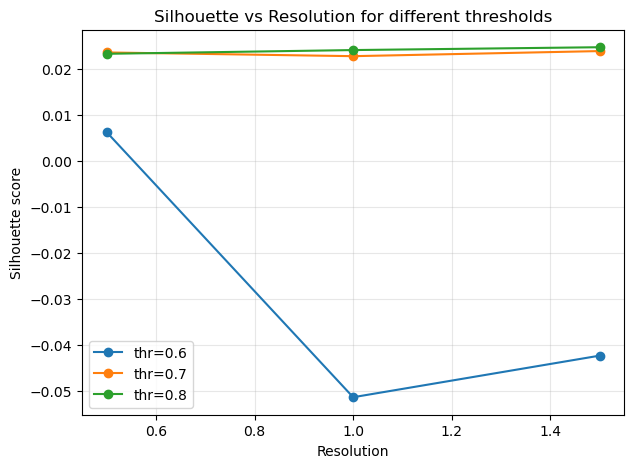

In [24]:
plt.figure(figsize=(7,5))
for thr in thresholds:
    sub = results_df[results_df["threshold"] == thr]
    sub_sorted = sub.sort_values("resolution")
    plt.plot(sub_sorted["resolution"], sub_sorted["silhouette"], marker="o", label=f"thr={thr}")
plt.xlabel("Resolution")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs Resolution for different thresholds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


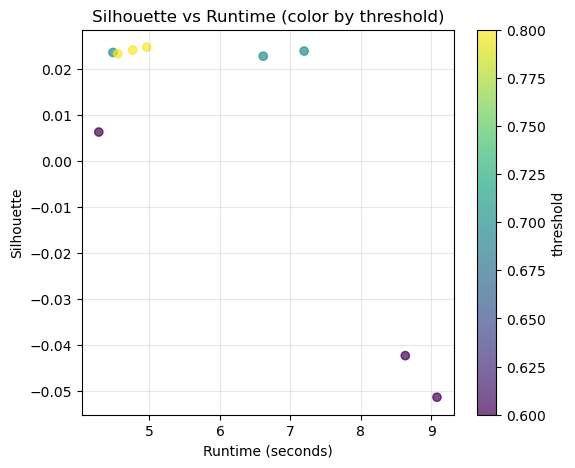

In [25]:
plt.figure(figsize=(6,5))
plt.scatter(results_df["runtime_sec"], results_df["silhouette"], c=results_df["threshold"], cmap="viridis", alpha=0.7)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Silhouette")
plt.title("Silhouette vs Runtime (color by threshold)")
plt.colorbar(label="threshold")
plt.grid(True, alpha=0.3)
plt.show()

##### Visualization of communities in 2D

In [26]:
# This may take a while if you have many nodes; you can sample or reduce dim first.
X_2d = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30).fit_transform(emb_norm)

def plot_partition_2d(labels, title=""):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=3, cmap="tab20")
    plt.title(title)
    plt.axis("off")
    plt.show()

c:\Users\samer\miniconda3\envs\videogame\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### 3.4 Recommendation Sytem with Louvains Graph

In [27]:
# Take the best configuration (top row in best_configs)
row = best_configs.iloc[0]
thr_best = row["threshold"]
res_best = row["resolution"]
seed_best = int(row["seed"])

print("Best config:", thr_best, res_best, seed_best)

# Get partition for that config
best_partition = partitions_cache[(thr_best, res_best, seed_best)]
labels_best = np.array([best_partition[i] for i in range(len(best_partition))])

Best config: 0.8 1.0 0


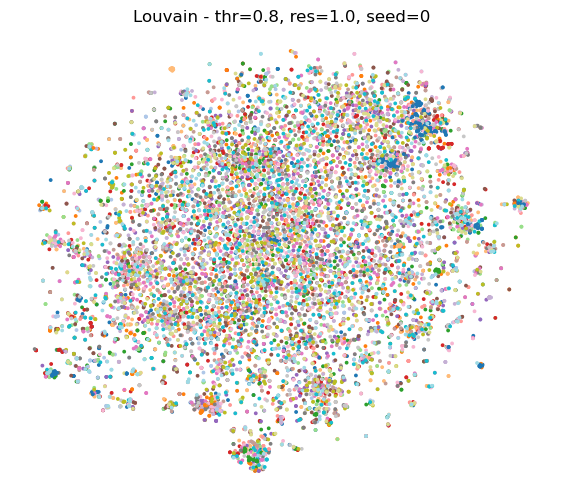

In [28]:
# Visualize communities in 2D
plot_partition_2d(labels_best, title=f"Louvain - thr={thr_best}, res={res_best}, seed={seed_best}")

# Pure Louvain

In [ ]:
_partition_cache = None
_graph_cache = None

def recommend_pure_louvain(game_id, embeddings_norm, topk=10):

    global _partition_cache, _graph_cache

    # Load partition
    if _partition_cache is None:
        print("Loading Louvain partition...")
        with open("partition_louvain_puro.pkl", "rb") as f:
            _partition_cache = pickle.load(f)

    # Load graph
    if _graph_cache is None:
        print("Loading Louvain graph...")
        with open("graph_louvain_puro.pkl", "rb") as f:
            _graph_cache = pickle.load(f)

    partition = _partition_cache
    G = _graph_cache
    cluster_id = partition[game_id]
    same_cluster = [
        j for j, c in partition.items()
        if c == cluster_id and j != game_id
    ]

    if len(same_cluster) == 0:
        print("Game is isolated; no recommendations.")
        return []

    sims = [
        (j, float(np.dot(embeddings_norm[game_id], embeddings_norm[j])))
        for j in same_cluster
    ]

    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topk]

### 3.5 Example of Recommendation by Purely Louvain

In [30]:
game_id = 42
print("Base game:", df.iloc[game_id]["name"])
recs = recommend_pure_louvain(game_id, emb_norm, df)
for idx, sim in recs:
    print(f"{df.iloc[idx]['name']} - sim={sim:.3f}")

IndexError: single positional indexer is out-of-bounds